In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf
from sklearn.feature_selection import mutual_info_regression

[0.1791322058894993, 0.17918499914737218, 0.17948068647522053, 0.17972245762937344, 0.18006824336229243, 0.1805641961091915, 0.1809942629693264, 0.18210008003956712, 0.18152089727513765, 0.18138981902955376, 0.18185668901304552, 0.18246619937598574, 0.18096739405906348, 0.1812147069299952, 0.18135544661140468, 0.18385456266943923, 0.18290619323828494, 0.18351232189314537, 0.18281237914872506, 0.18373704667914215, 0.1832331057104426, 0.18277577809171675, 0.1835595913007042, 0.1830783139281662, 0.18473722287739314, 0.18404280865077105, 0.1843963214949067, 0.1852413227714509, 0.18484915065895358, 0.18368222307705295, 0.18623635077079825, 0.1866214609046022, 0.18595551794016352, 0.18745657641041902, 0.1860456095814662, 0.18798948812621408, 0.18933663705688009, 0.1893511043011653, 0.18892368666973525, 0.19064079805870104, 0.19146549520514888, 0.19133174188893065, 0.19087223378610663, 0.19110435912777746, 0.19095507052299165, 0.19444443566321645, 0.19495201112214122, 0.1941518898715726, 0.19

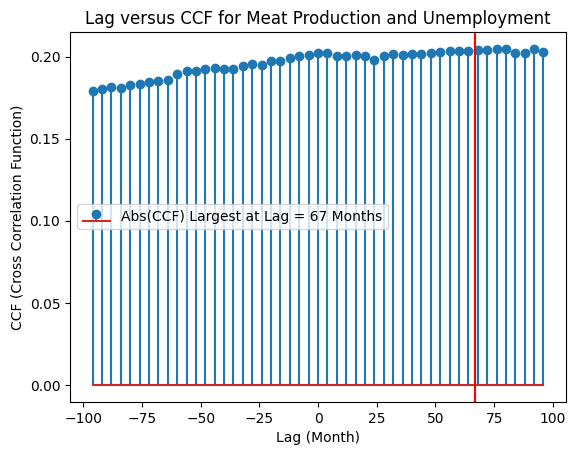

In [4]:
production_df = pd.read_csv('../cleaned-datasets/Cleaned_Meat_Stats_Meat_Production.csv')
economic_df = pd.read_csv('../cleaned-datasets/interpolated_economic_data.csv')
economic_df['Date'] = economic_df['date']

# Averaging data from top meatpacking and poultry processing states into one data point per year
condition_1_states = ["Nebraska", "Iowa", "Texas", "Kansas", "Illinois"]
condition_1 = economic_df["state"].isin(condition_1_states)
condition_2_states = ["Georgia", "Arkansas", "North Carolina", "Alabama", "Mississippi"]
condition_2 = economic_df['state'].isin(condition_2_states)
new_economic_df = economic_df[condition_1 | condition_2].copy()

# Merge datasets on 'Year'
data = pd.merge(production_df, new_economic_df, on='Date')
data.set_index('Date')

# Create an array of lag values
num = 96
lags = np.arange(-num, num + 1)

# aux fn for application
def gen_corr(l1, l2, lag: int) -> float:
    # Positive shift means front becomes NaN, negative shift means end becomes NaN
    if lag < 0:
        shifted_l1 = l1.copy().shift(-lag).dropna() 
        aligned_l2 = l2[:len(shifted_l1)] # align l2 to be the same length as l1
    else:
        shifted_l1 = l1.copy().shift(-lag).dropna() 
        aligned_l2 = l2[lag:]
        aligned_l2 = aligned_l2[:len(shifted_l1)] # Just in case?
        
    return mutual_info_regression(shifted_l1.values.reshape(-1, 1), aligned_l2.values)[0]
    
    # return mutual_info_regression(
    #     l1.shift(lag).dropna().values.reshape(-1, 1), l2.values[:-lag]
    # )
    
# generate correlations
# corr = [gen_corr(data['unemployment_rate'], data['Production'], -lag) for lag in lags if lag <= 0]
# corr += [gen_corr(data['Production'], data['unemployment_rate'], lag) for lag in lags if lag > 0]
corr = [gen_corr(data['unemployment_rate'], data['Production'], lag) for lag in lags]

# # Calculating cross-correlation for negative lags
# neg_ccf = ccf(data['unemployment_rate'], data['Production'])
# neg_ccf = neg_ccf[:num + 1][::-1]

# # Combine with non-negative lags
# pos_ccf = ccf(data['Production'], data['unemployment_rate'])
# all_ccf = list(neg_ccf) + list(pos_ccf[1:num + 1])

all_ccf = corr

print(all_ccf)

max_index = 0
for i in range(0, len(all_ccf)):
    if abs(all_ccf[i]) > abs(all_ccf[max_index]):
        max_index = i
print(max_index - num, all_ccf[max_index])

# Slice the arrays to make the graph less overwhelming
lags_sliced = lags[::4]
ccf_sliced = all_ccf[::4]

plt.stem(lags_sliced, ccf_sliced, label=f'Abs(CCF) Largest at Lag = {max_index - num} Months')
plt.xlabel('Lag (Month)')
plt.ylabel('CCF (Cross Correlation Function)')
plt.axvline(x=max_index - num, color="red")
# plt.ylim(-0.12, -0.08)
# plt.yticks(np.arange(-0.11, -0.08, 0.01)) # set y-axis ticks at intervals
plt.title('Lag versus CCF for Meat Production and Unemployment')
plt.legend()
plt.savefig('../visualizations/Lag Correlation Coefficients - MIR.png')
plt.show()